In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Probability.Distributions import RotatedBanana
from Models.NVP import NVP

tfd = tfp.distributions
tfb = tfp.bijectors

## Training the Model

First, we set up the normalizing flow so that it will save once every 5 epochs. In the next sections we will show how to load the saved model.

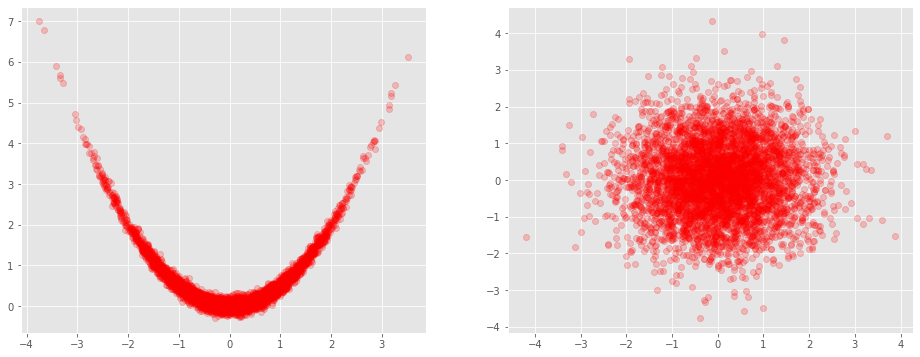

In [9]:
# Draw samples from both the target and the reference/latent space
num_samples = 5000
target = RotatedBanana(num_samples, 0.0)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [10]:
# Create model object and optimizer
def CreateModel(optimizer, latent_samples):
    nvp = NVP(num_layers=4, neuron_list=[75,75])
    nvp.compile(optimizer)
    # Perform a forward pass to initialize variables
    _ = nvp(latent)
    nvp.batch_norm_mode(False)
    return nvp

opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)

nvp = CreateModel(opt, latent)

In [11]:
# Setup checkpoints
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

In [12]:
# Define training options
n_epochs = 125
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
nvp.fit(dataset, epochs=n_epochs, callbacks=[cp_callback])  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 2.5308
Epoch 2/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 2.3355
Epoch 3/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 2.2016
Epoch 4/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 2.0694
Epoch 5/150
 94/100 [===========================>..] - ETA: 0s - negative likelihood: 1.9566
Epoch 00005: saving model to training_1/cp.ckpt
100/100 [==============================] - 0s 4ms/step - negative likelihood: 1.9489
Epoch 6/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 1.8459
Epoch 7/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 1.7443
Epoch 8/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 1.6634
Epoch 9/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 1.583

100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5643
Epoch 68/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5676
Epoch 69/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5664
Epoch 70/150
 98/100 [============================>.] - ETA: 0s - negative likelihood: 0.5604
Epoch 00070: saving model to training_1/cp.ckpt
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5592
Epoch 71/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5590
Epoch 72/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5565
Epoch 73/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5620
Epoch 74/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5578
Epoch 75/150
 87/100 [=========================>....] - ETA: 0s - negative likelihood: 0.5560
Epoch 

100/100 [==============================] - 1s 6ms/step - negative likelihood: 0.5338
Epoch 134/150
100/100 [==============================] - 1s 6ms/step - negative likelihood: 0.5326
Epoch 135/150
 99/100 [============================>.] - ETA: 0s - negative likelihood: 0.5325
Epoch 00135: saving model to training_1/cp.ckpt
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5307
Epoch 136/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5284
Epoch 137/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5295
Epoch 138/150
100/100 [==============================] - 0s 3ms/step - negative likelihood: 0.5327
Epoch 139/150
100/100 [==============================] - 0s 4ms/step - negative likelihood: 0.5305
Epoch 140/150
 89/100 [=========================>....] - ETA: 0s - negative likelihood: 0.5317
Epoch 00140: saving model to training_1/cp.ckpt
100/100 [==============================] - 0s 4ms

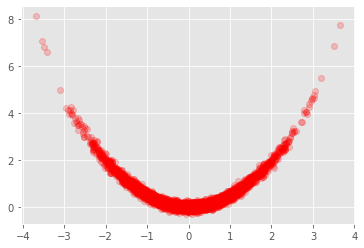

In [13]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)

## Loading the saved model
Now, we demonstrate how to load the saved model.

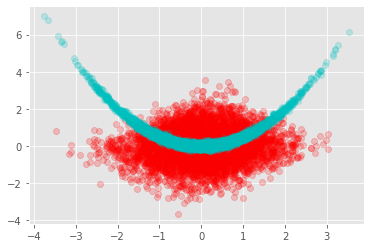

In [17]:
# Create new model object to load the data into 
unsaved_nvp = CreateModel(opt, latent)

# First, show that it is untrained
forward_pass = unsaved_nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:,0], forward_pass[:,1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

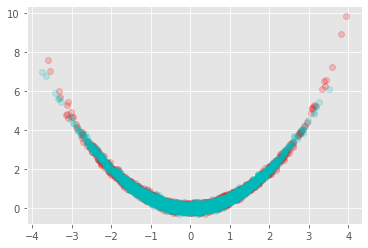

In [18]:
# Now, load the weights
unsaved_nvp.load_weights(checkpoint_path)

# It should be trained
forward_pass = unsaved_nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:,0], forward_pass[:,1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)